# Hyperspectral to RGB Image Conversion

## Computational Photography - Assignment 2

x4liu@eng.ucsd.edu

### Problem Definition:

In this assignment, we are going to implement the program that takes a 31 channels multi-spectral image and map it into the RGB image. In this problem, we are given a bundle of hyperspectral imagery taken at at the range of wavelength from 410 nm to 710nm (inclusive). To achieve such mapping, we need to conduct the following steps:
1. Load the Relative Spectral Power Distribution Function of CIE standard illuminant D65 at the given range of wavelength
2. Load the color matching functions of CIE 1931 standard colorimetric observation values at the given range of wavelength
3. Calculate the linear transformation matrix from Hyper-spectral image space to linear RGB space at a given wavelength
4. Fuse the images at the various wavelength together and save it as 8 bit per sample PNG file format 

In [95]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
from matplotlib import pyplot as plt

## Part 1: Spectral Power Distribution and Color Observation Matching Function

---

### Importing Data of Spectral Power Distribution and Color Observer Matching Function from Excel SpreadSheet

In [2]:
!wget http://files.cie.co.at/204.xls 

--2020-04-15 14:47:08--  http://files.cie.co.at/204.xls
Resolving files.cie.co.at (files.cie.co.at)... 77.244.243.43
Connecting to files.cie.co.at (files.cie.co.at)|77.244.243.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53248 (52K) [application/vnd.ms-excel]
Saving to: ‘204.xls’

204.xls             100%[===================>]  52.00K   102KB/s    in 0.5s    

2020-04-15 14:47:10 (102 KB/s) - ‘204.xls’ saved [53248/53248]



In [4]:
xl = pd.ExcelFile('204.xls')
print("Spread Sheet Names: ", xl.sheet_names)

Spread Sheet Names:  ['Ill. A', 'D65', 'Daylight comp', '1931 col observer', '1964 col observer']


**Here we want to get the spectral power distribution from D65 spreadsheet**
**And the color matching function from 1931 col observer spreadsheet**

In [9]:
D65 = pd.read_excel("204.xls", sheet_name='D65').dropna().iloc[1:, :]
col_obs_fn = pd.read_excel("204.xls", sheet_name='1931 col observer').dropna().iloc[:-1, :]

**Storing both value distribution function to dictionary indexing by the wavelength (nm)**

In [15]:
col_observer = {}
for i in range(col_obs_fn.shape[0]):
    col_observer[int(col_obs_fn.iloc[i, 0])] = np.array(col_obs_fn.iloc[i, 1:])
spd = {}
for i in range(D65.shape[0]):
    spd[int(D65.iloc[i, 0])] = float(D65.iloc[i, 1])

### Plot the Spectral Power Distribution and Color Observation Matching Function

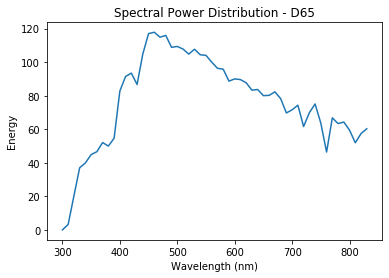

In [20]:
plt.plot(list(spd.keys()), [spd[i] for i in spd.keys()])
plt.title('Spectral Power Distribution - D65')
plt.ylabel('Energy')
plt.xlabel('Wavelength (nm)')
plt.savefig('SPD_D65.png', dpi=100)
plt.show()

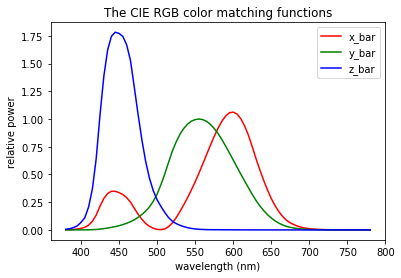

In [22]:
plt.plot(list(col_observer.keys()), [col_observer[i][0] for i in col_observer.keys()], label='x_bar', color='r')
plt.plot(list(col_observer.keys()), [col_observer[i][1] for i in col_observer.keys()], label='y_bar', color='g')
plt.plot(list(col_observer.keys()), [col_observer[i][2] for i in col_observer.keys()], label='z_bar', color='b')
plt.title("The CIE RGB color matching functions")
plt.xlabel("wavelength (nm)")
plt.ylabel("relative power")
plt.legend()
plt.savefig("color_matching_functions.png", dpi=100)
plt.show()

## Part 2: Calculating the Transformation Matrix from HSI to RGB space

---

**Utility Code from Previous Chromaticities Color Assignment and the Transformation Matrix from HSI to XYZ**

In [88]:
# sRGB chromaticities: 
# red: x, y, green: x, y, blue: x, y, white: x, y
chroma = np.array([[0.64, 0.33],
                   [0.3, 0.6],
                   [0.15, 0.06],
                   [0.3127, 0.329]])
def transformationMatrixRGBToXYZ(chroma):
    # set sRGB Chromaticities
    # calculate the whitepoint XYZ
    white_point = np.array([chroma[-1,0]/chroma[-1,1], 1, (1-chroma[-1,0]-chroma[-1,1])/chroma[-1,1]]).reshape(3,1)
    # matrix RGB chromaticities
    mat_Chroma = np.array([[chroma[0,0], chroma[1,0], chroma[2,0]],
                           [chroma[0,1], chroma[1,1], chroma[2,1]],
                           [1-chroma[0,0]-chroma[0,1], 1-chroma[1,0]-chroma[1,1], 1-chroma[2,0]-chroma[2,1]]])
    # solve XYZ
    gXYZ = np.linalg.inv(mat_Chroma) @ white_point
    return mat_Chroma @ np.diag(gXYZ.flatten())

def linear2sRGB(x):
    x = np.clip(x, 0, 1)
    thres = 0.0031308
    if x <= thres:
        return 12.92 * x
    else:
        return 1.055 * x ** (1/2.4) - 0.055
# vectorize into numpy function
linear2sRGB = np.vectorize(linear2sRGB)

In [89]:
def transformationMatrixHyperspectralToXYZ_D65():
    spd_v = np.array([spd[int(i)] for i in wavelength]).reshape(1,31)
    xyz_bar = np.array([col_observer[int(i)] for i in wavelength]).T
    M = (spd_v * xyz_bar)
    # normalize
    M /= M[1, :].sum()
    assert np.allclose(np.sum(M, axis=1)[1], 1)

    M_rgb2xyz = transformationMatrixRGBToXYZ(chroma)

    M_xyz2rgb = np.linalg.inv(M_rgb2xyz)
    M_hsi2rgb = M_xyz2rgb @ M.astype(np.float)
    return M_hsi2rgb

**Printing out the M matrix for HSI 2 RGB Transformation**

In [90]:
pd.DataFrame(M.round(10).T)

,0,1,2
0,0.003095,-0.002709,0.019169
1,0.009503,-0.008481,0.060928
2,0.017343,-0.016065,0.121247
3,0.022062,-0.022015,0.184722
4,0.016345,-0.020036,0.208631
5,0.002001,-0.011142,0.197154
6,-0.016169,0.003786,0.147111
7,-0.033912,0.022148,0.091743
8,-0.046135,0.038982,0.046447
9,-0.063784,0.063389,0.022963


## Part 3: Use HSI To RGB Transformation Matrix to Create sRGB Images, and Save in  PNG File Format

---

**Here we are going to aggregate the HSI image with transformation matrix sparsely. The trick to do so is instead of creating a big sparse matrix, we are going to do this iteratively**

**Importing the Files and Associating these Images with the right wavelength**

More detailed data reading see README.txt inside each data folder. Overall, we will represent the value by reading the pixel value in 8 bit sample PNG format and divide it by 255 to get the floating value that is the true relative power of the image in a specific wavelength

In [100]:
# there are three folders: scene 7, scene 4 and scene 5
# each scene folder contains around 31 images with name: reflectance{1 - 31}.png
scene = 7
images = []
imgsPath = []
folder = '.'
wavelength = [i for i in range(410, 711, 10)] # in nano meter
for i in range(1, 32):
    imgpath = f"images/scene{scene}/reflectance{i}.png"
    imgsPath.append(imgpath)
    image = cv2.imread(os.path.join(folder, imgpath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.array(image / 255.0).astype(np.float))
print("Wavelength and Image Pair\n")
print('\n'.join([f"wavelength (nm): {lam}, img (path): {img}" for (lam, img) in zip(wavelength, imgsPath)]))

Wavelength and Image Pair

wavelength (nm): 410, img (path): images/scene7/reflectance1.png
wavelength (nm): 420, img (path): images/scene7/reflectance2.png
wavelength (nm): 430, img (path): images/scene7/reflectance3.png
wavelength (nm): 440, img (path): images/scene7/reflectance4.png
wavelength (nm): 450, img (path): images/scene7/reflectance5.png
wavelength (nm): 460, img (path): images/scene7/reflectance6.png
wavelength (nm): 470, img (path): images/scene7/reflectance7.png
wavelength (nm): 480, img (path): images/scene7/reflectance8.png
wavelength (nm): 490, img (path): images/scene7/reflectance9.png
wavelength (nm): 500, img (path): images/scene7/reflectance10.png
wavelength (nm): 510, img (path): images/scene7/reflectance11.png
wavelength (nm): 520, img (path): images/scene7/reflectance12.png
wavelength (nm): 530, img (path): images/scene7/reflectance13.png
wavelength (nm): 540, img (path): images/scene7/reflectance14.png
wavelength (nm): 550, img (path): images/scene7/reflectanc

In [101]:
rgb = np.zeros((3, images[0].shape[0] * images[0].shape[1]))
for i, img in enumerate(images):
    m = M[:, i].reshape(3,1)
    img = np.transpose(img, (2, 0, 1))
    img_flatten = img.reshape(3,-1)
    rgb += m * img_flatten
rgb = rgb.reshape(3, images[0].shape[0], images[0].shape[1])
rgb = np.transpose(rgb, (1, 2, 0))

img_data = (linear2sRGB(rgb) * 255.0).round(0).astype(np.uint8)

**The resulting image plotted and saved**

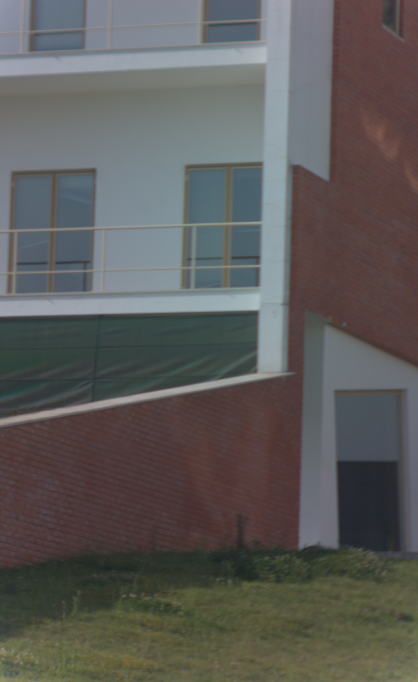

In [102]:
img = Image.fromarray(img_data, "RGB")
img

In [103]:
img.save(f"scene{scene}_rgb.png", "PNG")

# Part 3 

---

## Brief Discussion on HSI to RGB Image Processing

In this assignment we performed the hyperspectral image to RGB image transformation. From color matching function, we can see that the color green is most prominent in range 520 nm to 540 nm, if we inspect the reflectance image at this wavelength, we can see that the image highlights the grass part, which is green in the RGB reconstructed image. Also note that since the wall of the building is white, almost all the reflectant images highlighted the white section of the building. This is because the color white is a mixture of all channels. 